## Задание 

Нужно предложить и обосновать подход для группировки идентичных наименований товаров.

 Пример входа:

* [1] "Кисломолочный напиток Актимель ежевично-черничный 100 г" 
* [2] "Напиток Данон Актимель черника/ежевика 2,5% 6*0,1л Россия" 
* [3] "Гель для душа Роскошная мягкость Черная орхидея Palmolive, 250 мл"
* [4] "Гель Palmolive Naturals д/душа Роскошная мягкость Черная орхидея 250мл Италия" 
* [5] "Гель для душа Palmolive "Черная орхидея" 250 мл" 
* [6] "Корм Whiskas говядина/кролик канапе новогодний 85г Россия" 

Пример выхода: [1 2] [3 4 5] 6 (см. вложенный файл)

Файл: test_task_NLP.json

# Решение
### Загрузка данных
Мы могли бы использовать данные из демонстрационного примера, но в нём всего лишь 6 строк. Чтобы получить больший датасет, мы можем использовать данные из вложенного файла с примером выхода. Для этого данные необходимо привести к начальному состоянию с помощью декластеризации и перемешивания.

In [1]:
import json
from gensim.models import Word2Vec
import re
import random

In [2]:
def load_data(full=True):
    if full:
        with open('test_task_NLP.json', 'r') as f:
            data = json.load(f)
        print('Full data clusters number', len(data))
        for t in data:
            print(t)
        data = [s for cluster in data for s in cluster]
        random.shuffle(data)
    else:
        data = [
            'Кисломолочный напиток Актимель ежевично-черничный 100 г',
            'Напиток Данон Актимель черника/ежевика 2,5% 6*0,1л Россия',
            'Гель для душа Роскошная мягкость Черная орхидея Palmolive, 250 мл',
            'Гель Palmolive Naturals д/душа Роскошная мягкость Черная орхидея 250мл Италия',
            'Гель для душа Palmolive "Черная орхидея" 250 мл',
            'Корм Whiskas говядина/кролик канапе новогодний 85г Россия'
        ]
    print('len(data):', len(data))
    return data


data_full = load_data(full=True)
data_short = load_data(full=False)

Full data clusters number 1223
['Баклажаны с орехами упак', 'Баклажаны с творожной начинкой от бренд-шефа АВ']
['Блинчики с курицей упак (4 шт)', 'Блинчики с мясом, Уже Готово , 140 г']
['Блинчики с мясом упак (4 шт)', 'Блинчики с мясом, Уже Готово , 220 г, Россия']
['Блины без начинки упак', 'Блины Русские от бренд-шефа АВ, Россия']
['Винегрет упак', 'Салат FreshSecret Винегрет 600г', 'Винегрет с ароматным подсолнечным маслом, Уже Готово , 350 г']
['Голубцы мясные тушеные в томатно-сливочном соусе от бренд-шефа АВ', 'Голубцы мясные упак', 'Голубцы мясные упак']
['Запеканка творожная President Дольче ванильная 5,5% 350г', 'Запеканка творожная упак', 'Запеканка творожная с изюмом, Уже Готово , 300 г']
['Морковь по-корейски', 'Морковь по-корейски упак', 'Салат FreshSecret Морковь по-корейски, 250г', 'Морковь по-корейски, Уже Готово , 250 г']
['Оладьи из кабачков упак', 'Оладьи из кабачков, Уже Готово , 250 г']
['Плов с мясом баранины упак', 'Плов узбекский от бренд-шефа АВ']
['Салат Коул

В примере текста присутствуют ошибки кластеризации, например

['Тампоны Kotex Super 16шт Чехия', 'Тампоны KOTEX super, 16 шт', 'Kotex тампоны супер, 24ш']<br>
['Бананы 1,0-1,3кг', 'Бананы связка 0.5-1.1кг', 'Бананы, Просто Азбука , Эквадор', 'Бананы Кавендыш Эквадор']<br>
['Батончик Bounty 55г', 'Батончик Bounty Trio 82.5г Россия', 'Батончик BOUNTY шоколадный трио, 82,5г', 'Шок.батончик BOUNTY Trio 82,5г', 'Батончик Bounty Trio 3шт*27.5г', 'Шоколадный батончик "Баунти Трио" 85г']<br>
['Булочка Улитка с корицей 85г Франция', 'Булочка Датская с корицей Mette Munk 80 г Дания']<br>

### Токенизация

#### Проблемы текста (неконсистентность):
1. Иногда единицы измерения указаны слитно с количеством, иногда раздельно, например "180г" и "180 г"
2. Проценты во всех случаях, кроме одного, указаны слитно с числом. Единственный случай: 'Сливки Домик в деревне 20 % 480г Россия'
3. Литры указаны как 'l' и 'л'
4. Граммы указаны как 'г' и 'гр'
5. Разделитель десятичной части '.' и ','. Например, '0,7' и '0.7'
6. Случаи продажи комплектами обозначаются 
    * 25пак*1,5г
    * 6шт*100г
    * 24*0.5 л
    * 3л*30шт
    * 2шт.*340г
    * 2*64шт
7. Состав указан как 'ежевично-черничный' или 'ежевика/черника'
8. Для одного и того же продукта иногда указан объём, а иногда вес, например '0.1л' и '100 г'
9. Возможны случаи использования разных единиц измерения для одинакового товара, например, <br> 
`Средство экологичное BioMio BIO-Sensitive для стирки деликатных тканей концентрат, 1,5л` и <br> 
`Кондиционер Bio Mio Эвкалипт д/белья концентрат 1500мл Россия`
10. Обозначения могут быть указаны по-разному `Коньяк Courvoisier Fine Champagne V.S.O.P. 0,5L в подарочной упаковке` <br> и `Коньяк Courvoisier VSOP в п/у 0.5л Франция`. На данный момент такие случаи не обрабатывались.
11. Названия могут быть на русском и английском языках `Биойогурт питьевой Danone Активиа 2,2% клубника-земляника 290г Россия` и `Биойогурт Данон Активиа питьевой дыня/земляника 2,0% 290г Россия`. Эти случаи на данный момент не обрабатывались. Хотя это может существенно повлиять на качество кластеризации.


#### Решение
1. Все случаи разбивались на два слова: число и единицу измерения
2. Варианты: оставлять число слитно с процентом, либо оставлять только число. В данной реализации выбран первый вариант, хотя по идее в таком случае нужно было бы сначала преобразовать '20 %' в '20%'
3. Все единицы переведены в 'л'
4. Все единицы переведены в 'г'
5. Для всех чисел десятичный разделитель конвертирован в запятую.
6. Такие случаи никак особенно не обрабатывались, а просто разбивались на числа и слова, например, <br> `'25пак*1,5г' -> '25', 'пак', '1,5', 'г'`
7. Такие случаи никак особенно не обрабатывались, просто разбивались на два слова
8. Такие случаи являются исключениями, т.к. вес не должен сооответствовать объёму, это разные параметры. Поэтому такие случаи не обрабатывались
9. Здесь можно было бы переводить все объёмы в диапазоне от 100 мл в литры, и все веса от 100 г в кг. Либо переводить все объёмы в миллилитры и веса в граммы. Пока что такие случаи не обрабатывал. Такая обработка может ухудшить кластеризацию, т.к. в каких-то случаях может не быть указаны единицы измерения, либо указан диапазон значений.
10. Пока не обрабатывались.
11. Пока не обрабатывались.

Также процессе токенизации буквенные символы переводились в нижний регистр

In [3]:
def tokenize(data):
    def convert(s):
        mapping = {'l': 'л', 'гр': 'г'}
        if s in mapping:
            return mapping[s]
        return s.replace('.', ',')
        
    data1 = [re.findall(r'[0-9,.]+|\w+', line.lower()) for line in data]
    data1 = [[convert(s)  for s in line if s not in '.,'] for line in data1]
    return data1


tokens_full = tokenize(data_full)
tokens_short = tokenize(data_short)

### Preprocessing data

Нормализация (стемминг и лемматизация) могут ухудшить кластеризацию, 
т.к. "торт вишнёвый" и "варенье вишнёвое" станут близкими словами, 
а для нас желательно понимать к какому существительному относится прилагательное

Стоп слова выбрасывать не нужно, т.к. они могут нести полезный смысл.

Хотя можно попробовать. Для этого нужно определить метрики и протестировать разные подходы.

### Векторизация, выделение признаков
Добавим n-граммы длиной 2

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd


# склеим строки обратно, чтобы пустить в векторизатор
def tokens_to_vectors(tokens):
    print('Всего уникальных слов:', len(set([item for sublist in tokens for item in sublist])))
    data_p = [' '.join(word_list) for word_list in tokens]
    print('Длина массива после склейки', len(data_p))

    vectorizer = TfidfVectorizer(token_pattern='[\w.,]*', ngram_range=(1, 2))
    X = vectorizer.fit_transform(data_p)
    print('Таблица векторов', X.toarray().shape)
    
    return X, vectorizer

vectors_full, vectorizer_full = tokens_to_vectors(tokens_full)
vectors_short, vectorizer_short = tokens_to_vectors(tokens_short)

#idf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

Всего уникальных слов: 3148
Длина массива после склейки 3580
Таблица векторов (3580, 9255)
Всего уникальных слов: 35
Длина массива после склейки 6
Таблица векторов (6, 103)


Напишем функцию для выгрузки данных в нужном формате по разметке.

In [5]:
def labels_to_res(data, labels):
    res = {}
    for k, v in zip(labels, data):
        if k not in res:
            res[k] = []
        res[k].append(v)
    return [v for _,v in res.items()]

### Метрика качества
Чтобы грубо измерить кластеризации, будем сравнивать полученное количество кластеров с имеющимся количеством кластеров в приложенном файле. В файле 1223 кластера.

Кроме этого, будем смотреть на качество, просматривая полученные группы.

### Алгоритмы кластеризации
Реализуем несколько вариантов кластеризации. Начнём для разогрева с KMeans. Для него нужно знать количество кластеров, в полевых условиях мы этого знать не будем, но протестировать на коротких данных можно.

In [6]:
from sklearn.cluster import KMeans

def k_means(X, cl_num, vectorizer):
    km = KMeans(n_clusters=cl_num)
    km.fit(X)

    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(cl_num):
        top_ten_words = [terms[ind] for ind in order_centroids[i, :9]]
        print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

    print()
    print('Разметка кластеров', km.labels_)
    
k_means(vectors_short, 3, vectorizer_short)

Top terms per cluster:
Cluster 0:   palmolive 250  palmolive palmolive   черная  орхидея гель гель 
Cluster 1:   говядина 85  whiskas whiskas  говядина говядина   новогодний  кролик
Cluster 2:  напиток   актимель актимель  напиток актимель черничный   черничный черничный

Разметка кластеров [2 2 0 0 0 1]


Работает. Попробуем другие модели.

In [7]:
from sklearn.cluster import dbscan
import sklearn

def db_scan(X, vectorizer):
    res = dbscan(X, 
                 #algorithm='kd_tree', 
                 min_samples=1,
                 metric='cosine',
                 eps=0.33)
    print(res)
    print('Clusters number', len(set(res[1])))
    return res[1]

    
bd_clusters_short = db_scan(vectors_short, vectorizer_short)
bd_clusters_full = db_scan(vectors_full, vectorizer_full)

(array([0, 1, 2, 3, 4, 5]), array([0, 1, 2, 2, 2, 3]))
Clusters number 4
(array([   0,    1,    2, ..., 3577, 3578, 3579]), array([   0,    1,    2, ..., 1265,  185,  637]))
Clusters number 1266


Посмотрим на результаты

In [8]:
labels_to_res(data_short, bd_clusters_short)
print()
labels_to_res(data_full, bd_clusters_full)

[['Пиво LEFFE Brune, 0,33л',
  'Пиво темное Leffe Brune 6.5% 0.33 л бутылка Бельгия',
  'Пиво Leffe Brune темное 0,33л Бельгия'],
 ['Пюре ФрутоНяня из яблок и бананов с творогом для детей с 6 месяцев, 90г',
  'Пюре ФРУТОНЯНЯ из яблок и абрикосов со сливками, 90г',
  'Сок ФрутоНяНя из яблок осветленный с 3 лет 500мл Россия',
  'Пюре ФрутоНяНя из яблок/абрикос/сливок с 6 мес 90г Россия',
  'Пюре ФРУТОНЯНЯ из яблок, 90 г',
  'Пюре из яблок, банана и клубники, ФрутоНяня , 90 г, Россия',
  'Пюре ФрутоНяНя из яблок/шиповник/клюква с 5 мес 90г Россия',
  'Пюре ФрутоНяНя из яблок с 4 мес 90г Россия',
  'Пюре ФрутоНяНя из яблок/банан/творог с 6 мес 90г Россия',
  'Сок ФрутоНяНя Малышам из яблок осветленный с 4 мес 200мл Россия',
  'Пюре ФРУТОНЯНЯ из яблок и бананов с творогом, 90г',
  'Пюре ФрутоНяня из яблок и абрикосов со сливками для детей с 6 месяцев, 90г',
  'Пюре ФрутоНяня гипоаллергенное из яблок для детей с 4 месяцев, 90г'],
 ['Пиво Хамовники Пильзенское ст/б 0,47л Россия',
  'Пиво Хамо

In [9]:
from sklearn.cluster import AgglomerativeClustering


def agg_clustering(X, treshold):
    tree = AgglomerativeClustering(n_clusters=None,
                                   #affinity='cosine', 
                                   distance_threshold=treshold,
                                   #linkage='complete'
                                  )
    tree.fit(X)
    print(tree.n_clusters_)
    print(tree.labels_)
    return tree.labels_

    
#print(vectors_short.toarray())
agg_labels_short = agg_clustering(vectors_short.toarray(), treshold=1.22)
agg_labels_full = agg_clustering(vectors_full.toarray(), treshold=1.1)

2
[0 0 1 1 1 0]
1260
[ 528 1098  307 ...  424 1150   53]


In [10]:
labels_to_res(data_short, agg_labels_short)
print()
labels_to_res(data_full, agg_labels_full)

[['Пиво LEFFE Brune, 0,33л',
  'Пиво темное Leffe Brune 6.5% 0.33 л бутылка Бельгия',
  'Пиво Leffe Brune темное 0,33л Бельгия'],
 ['Пюре ФрутоНяня из яблок и бананов с творогом для детей с 6 месяцев, 90г',
  'Пюре ФРУТОНЯНЯ из яблок и бананов с творогом, 90г'],
 ['Пиво Хамовники Пильзенское ст/б 0,47л Россия',
  'Пиво Хамовники Венское светлое ст/б 0,47л Россия',
  'Пиво Старопрамен светлое ст/б 0,47л Россия'],
 ['Сельдерей черешковый 1шт'],
 ['Сок Rich Благородное Яблоко 1л',
  'Сок Rich Зеленое яблоко, 1 л Россия',
  'Сок RICH Яблоко, 1 л',
  'Сок Rich Яблоко 1л Россия'],
 ['Виски GLENMORANGIE Quinta Ruban, 0,7л',
  'Виски Glenmorangie Quinta Ruban в п/у 0,7л Шотландия'],
 ['Кетчуп Heinz для гриля и шашлыка 350мл',
  'Кетчуп Heinz для гриля и шашлыка (с дозатором) 350г',
  'Кетчуп Heinz для гриля и шашлыка 350г Россия'],
 ['Вобла вяленая 20+, Россия',
  'Корюшка вяленая весовая Россия',
  'Вобла вяленая весовая Россия'],
 ['Базилик Московский в горшочке 100г Россия',
  'Базилик АГРО

До какой-то степени кластеризация работает. Можно заметить, что часто появляются ошибки из-за того, что текст наименования полностью соответствует с точностью до объёма/массы. 

Модель можно улучшить, сравнивая объёмы/массы товаров. Если они отличаются у двух наименований, то наименования разные. Если нет, то скорее всего, наименования одинаковые.

Также можно попробовать разные варианты нормализации текста.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage


def show_dendrogram(X, xsize=15):

    X = X.toarray()
    print(X.shape)
    Z = linkage(X, 'ward')
    print("Z.shape:", Z.shape)
    # Z has the format [idx1, idx2, dist, sample_count]
    # therefore, its size will be (N-1, 4)

    # from documentation:
    # A (n-1) by 4 matrix Z is returned. At the i-th iteration,
    # clusters with indices Z[i, 0] and Z[i, 1] are combined to
    # form cluster n + i. A cluster with an index less than n
    # corresponds to one of the original observations.
    # The distance between clusters Z[i, 0] and Z[i, 1] is given
    # by Z[i, 2]. The fourth value Z[i, 3] represents the number
    # of original observations in the newly formed cluster.
    plt.figure(figsize=(15,15))
    plt.title("Ward")
    dendrogram(Z)
    plt.show()


In /home/andrey/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/andrey/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/andrey/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


(6, 103)
Z.shape: (5, 4)


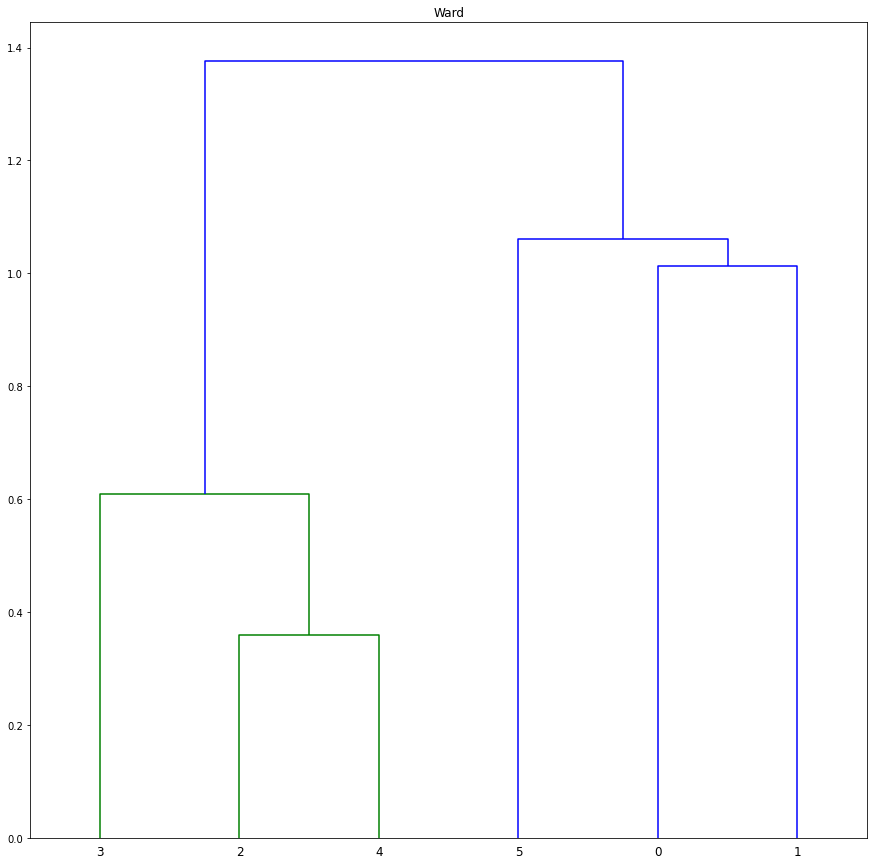

In [12]:
show_dendrogram(vectors_short)

(3580, 9255)
Z.shape: (3579, 4)


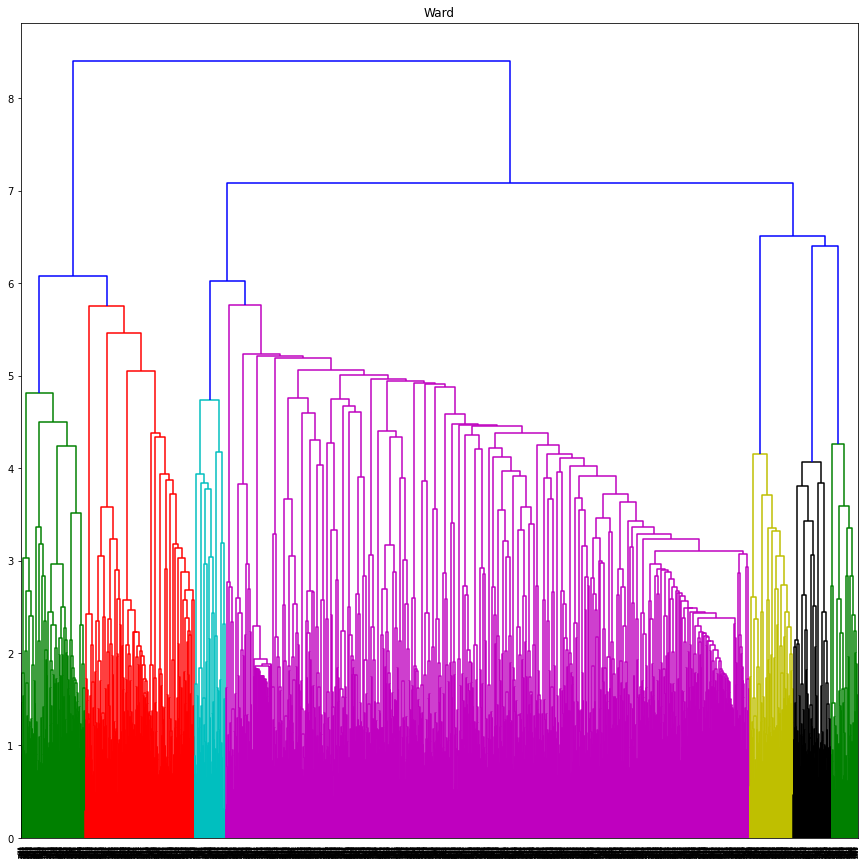

In [13]:
# takes some time
show_dendrogram(vectors_full, xsize=150)